In [4]:
import torch
import sys
import os
from tqdm import tqdm
import numpy as np
sys.path.append(".")
import seaborn as sns


In [5]:
#configs
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
path = 'output/aya_dataset_200000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240911152426/clients_adapters'
#path = 'output/aya_dataset_200000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240911093918/clients_adapters'
DEVICE = 'cuda'
n_clients = 20

In [6]:
def get_adapter(path, client, round = 50, layer = -1):
    adapter_path = path + f'/checkpoint-{round}_client{client}/adapter_model.bin' # Replace with your actual adapter checkpoint path
    adapter_path_global = 'output/aya_dataset_200000_fedavg_c20s2_i10_b16a1_l512_r8a16_20240911152426/checkpoint-49/adapter_model.bin'

    # Load the adapter weights from the checkpoint
    adapter_state_dict = torch.load(adapter_path, map_location='cpu')
    adapter_global = torch.load(adapter_path_global, map_location='cpu')

    # Access the adapter weights (as tensors)
    adapter_weights_A = [param for name, param in adapter_state_dict.items() if 'lora_A' in name]
    adapter_weights_B = [param for name, param in adapter_state_dict.items() if 'lora_B' in name]

    adapter_weights_A_global = [param for name, param in adapter_global.items() if 'lora_A' in name]
    adapter_weights_B_global = [param for name, param in adapter_global.items() if 'lora_B' in name]

    # Subtract the global adapter weights from the client adapter weights

    adapter_weights_A = adapter_weights_A[layer] - adapter_weights_A_global[layer]
    adapter_weights_B = adapter_weights_B[layer] - adapter_weights_B_global[layer]

    #adapter_weights_A = adapter_weights_A[layer]
    #adapter_weights_B = adapter_weights_B[layer]

    #flatten
    adapter_weights_A = adapter_weights_A.flatten()
    adapter_weights_B = adapter_weights_B.flatten()

    return adapter_weights_A,  adapter_weights_B

In [7]:
similarity_A = np.zeros((n_clients,n_clients))
similarity_B = np.zeros((n_clients,n_clients))

for c1 in list(range(n_clients)):
    print(f'Calculating similarity for {c1}')
    adapter_weights_A_c1, adapter_weights_B_c1 = get_adapter(path, client = c1, round = 50, layer = -1) 
    adapter_weights_A_c1 = adapter_weights_A_c1.cpu()
    adapter_weights_B_c1 = adapter_weights_B_c1.cpu()

    for c2 in list(range(n_clients)):
        adapter_weights_A_c2, adapter_weights_B_c2 = get_adapter(path, client = c2, round = 50, layer = -1)
        adapter_weights_A_c2 = adapter_weights_A_c2.cpu()
        adapter_weights_B_c2 = adapter_weights_B_c2.cpu()
        
        #cosine similarity
        cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
        cos_A = cos(adapter_weights_A_c1, adapter_weights_A_c2)
        cos_B = cos(adapter_weights_B_c1, adapter_weights_B_c2)
        similarity_A[c1][c2] = cos_A
        similarity_B[c1][c2] = cos_B

Calculating similarity for 0
Calculating similarity for 1
Calculating similarity for 2
Calculating similarity for 3
Calculating similarity for 4
Calculating similarity for 5
Calculating similarity for 6
Calculating similarity for 7
Calculating similarity for 8
Calculating similarity for 9
Calculating similarity for 10
Calculating similarity for 11
Calculating similarity for 12
Calculating similarity for 13
Calculating similarity for 14
Calculating similarity for 15
Calculating similarity for 16
Calculating similarity for 17
Calculating similarity for 18
Calculating similarity for 19


<Axes: >

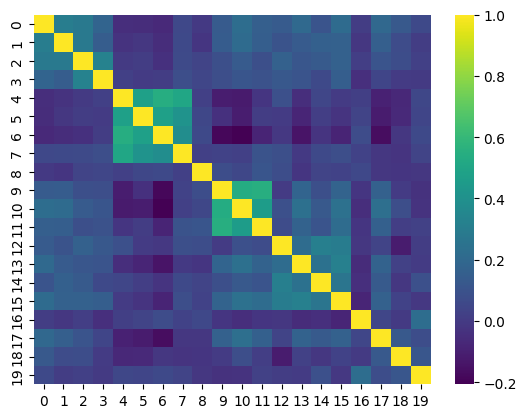

In [8]:
#principal diagonal to 0
sns.heatmap(similarity_A, cmap='viridis')

<Axes: >

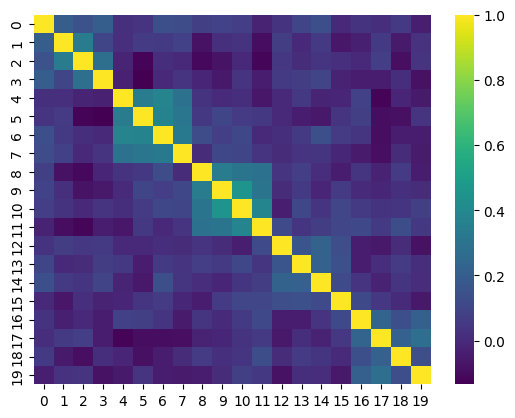

In [9]:
sns.heatmap(similarity_B, cmap='viridis')

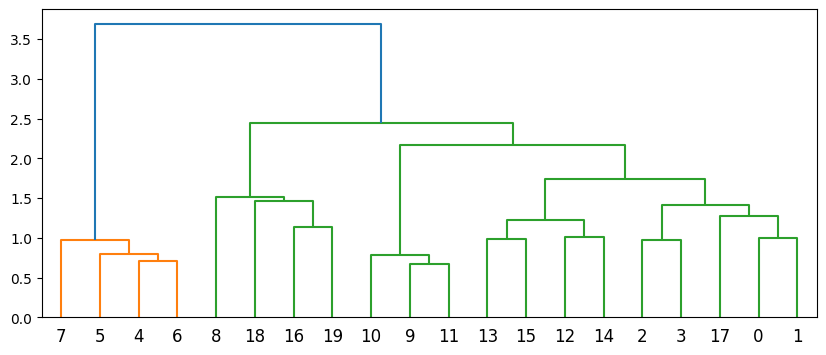

In [10]:
#hierarchicasl clustering 
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

p_dist = 1 - similarity_A
Z = linkage(p_dist, 'ward')
fig = plt.figure(figsize=(10, 4))
dn = dendrogram(Z)
plt.show()

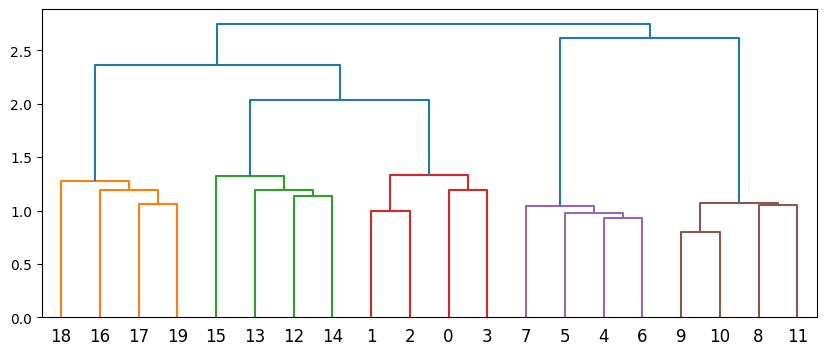

In [11]:
#hierarchicasl clustering 
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

p_dist = 1 - similarity_B
Z = linkage(p_dist, 'ward')
fig = plt.figure(figsize=(10, 4))
dn = dendrogram(Z)
plt.show()